In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import timm # PyTorch Image Models
import os

# CONFIGURATION
BATCH_SIZE = 8          # Keep low for 512x512 images
IMG_SIZE = 512          # Your target resolution
LEARNING_RATE = 0.001
EPOCHS = 10
NUM_CLASSES = 9         # You have 9 labels
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Using device: {DEVICE}")

# DATA TRANSFORMS
# We resize to 512x512 and normalize using standard ImageNet stats
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(), # Augmentation
        transforms.RandomRotation(10),     # Augmentation
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'valid': transforms.Compose([
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

Using device: cuda


In [2]:
# MAPPING
# Ensure this list matches the order of your folder numbers (0 to 8)
class_names = [
    'laptop_normal',    # 0
    'laptop_crack',     # 1
    'laptop_fades',     # 2
    'laptop_lines',     # 3
    'laptop_spot',      # 4
    'phone_dead_pixel', # 5
    'phone_scratch',    # 6
    'phone_crack',      # 7
    'phone_normal'      # 8
]

# DATASETS
data_dir = 'classification' # Your root folder containing train/valid/test
image_datasets = {
    x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x])
    for x in ['train', 'valid'] # Assuming you have a 'valid' folder
}

# DATALOADERS
dataloaders = {
    x: DataLoader(image_datasets[x], batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
    for x in ['train', 'valid']
}

print(f"Classes found: {image_datasets['train'].classes}") # Should be ['0', '1', ... '8']

Classes found: ['0', '1', '2', '3', '4', '5', '6', '7', '8']


In [3]:
# use 'resnet50' 
model = timm.create_model('resnet50', pretrained=True, num_classes=NUM_CLASSES)

model = model.to(DEVICE)

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

c:\Users\SEBASTIAN\AppData\Local\Programs\Python\Python310\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in D:\HF_MODELS\models--timm--resnet50.a1_in1k. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


In [4]:
def train_model(model, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(DEVICE)
                labels = labels.to(DEVICE)

                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + Optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(image_datasets[phase])
            epoch_acc = running_corrects.double() / len(image_datasets[phase])

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    return model

# START TRAINING
trained_model = train_model(model, criterion, optimizer, EPOCHS)

Epoch 1/10
----------
train Loss: 0.8519 Acc: 0.6734
valid Loss: 1.1665 Acc: 0.6882
Epoch 2/10
----------
train Loss: 0.5957 Acc: 0.7647
valid Loss: 0.8839 Acc: 0.7097
Epoch 3/10
----------
train Loss: 0.4772 Acc: 0.8093
valid Loss: 0.8698 Acc: 0.7312
Epoch 4/10
----------
train Loss: 0.3740 Acc: 0.8552
valid Loss: 0.9147 Acc: 0.7699
Epoch 5/10
----------
train Loss: 0.3319 Acc: 0.8686
valid Loss: 0.7246 Acc: 0.7613
Epoch 6/10
----------
train Loss: 0.2910 Acc: 0.8826
valid Loss: 0.7359 Acc: 0.7978
Epoch 7/10
----------
train Loss: 0.2303 Acc: 0.9135
valid Loss: 0.9957 Acc: 0.7613
Epoch 8/10
----------
train Loss: 0.1982 Acc: 0.9246
valid Loss: 0.7565 Acc: 0.7591
Epoch 9/10
----------
train Loss: 0.1659 Acc: 0.9385
valid Loss: 0.8634 Acc: 0.8151
Epoch 10/10
----------
train Loss: 0.1653 Acc: 0.9346
valid Loss: 0.9741 Acc: 0.7720


In [13]:
from PIL import Image

def predict_image(image_path, model):
    model.eval()
    
    # Process image
    img = Image.open(image_path).convert('RGB')
    transform = data_transforms['valid']
    img_t = transform(img).unsqueeze(0).to(DEVICE) # Add batch dimension
    
    with torch.no_grad():
        outputs = model(img_t)
        _, preds = torch.max(outputs, 1)
        
    predicted_idx = preds.item()
    predicted_label = class_names[predicted_idx]
    
    print(f"Prediction Index: {predicted_idx}")
    print(f"Prediction Label: {predicted_label}")
    return predicted_label


predict_image(r"D:\SEBASTIAN\AOL_AI\condition_classifier\classification\valid\0\f19_jpg.rf.bcd1b402caee2596eeaf017e8c281aa9.jpg", trained_model)


Prediction Index: 6
Prediction Label: phone_scratch


'phone_scratch'

In [6]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

def get_all_preds(model, loader, device):
    all_preds = []
    all_labels = []
    
    model.eval() # Set model to evaluation mode
    
    with torch.no_grad(): # Turn off gradients to save memory
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            
            # Move to CPU and convert to numpy
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            
    return np.array(all_preds), np.array(all_labels)

# Run this on your 'valid' or 'test' dataloader
# Assuming 'trained_model', 'dataloaders', and 'DEVICE' are defined from previous steps
y_pred, y_true = get_all_preds(trained_model, dataloaders['valid'], DEVICE)

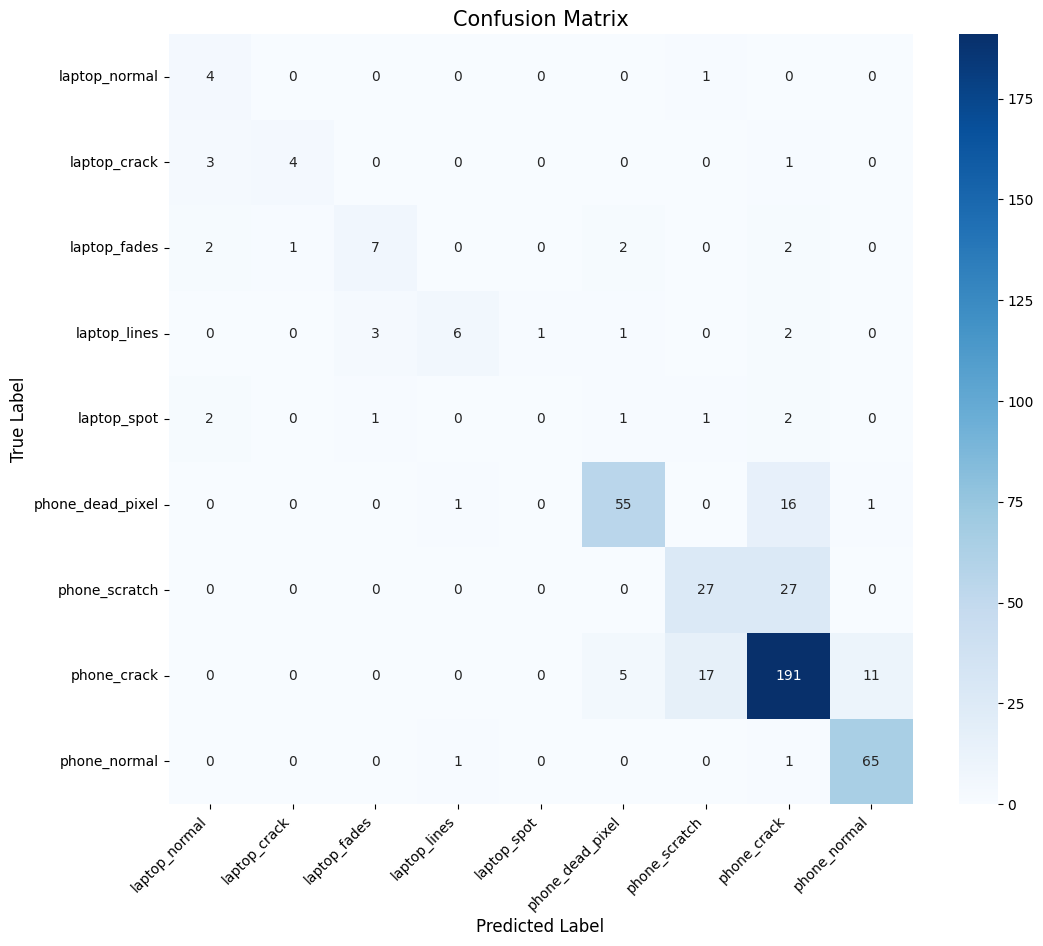

In [8]:
# Your exact class names in order 0-8
class_names = [
    'laptop_normal', 'laptop_crack', 'laptop_fades', 
    'laptop_lines', 'laptop_spot', 'phone_dead_pixel', 
    'phone_scratch', 'phone_crack', 'phone_normal'
]

# Calculate Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Plotting
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names)

plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('Confusion Matrix', fontsize=15)
plt.xticks(rotation=45, ha='right')
plt.show()